In [259]:
import pandas as pd
import geopandas as gpd
import os
import pylab as plt
from pyEmdat.emdat_df import emdat
import geocoder
import datetime
%pylab inline

data = os.getenv('data')

Populating the interactive namespace from numpy and matplotlib


/home/nicholasjones/miniconda3/envs/GPD3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Parsing the location field of EMDAT

#### 1. Load downloaded Excel file as a PyEmdat object

In [260]:
ED = emdat((data + '/emdat_1960.xlsx'))

/home/nicholasjones/Code/pyEmdat/emdat_df.py:39: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  self.data = pd.read_excel(filename, header = 6, parse_dates=['Year']).rename(columns = cols_dict)


#### 2. Summary for India by hazard

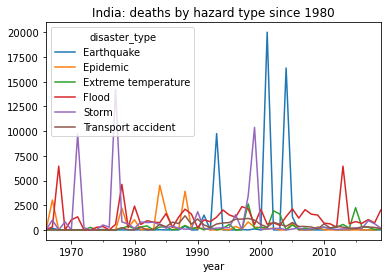

In [261]:
df = ED.disaster_stats_timeseries(1965, 2020, 'India','all','deaths')
cols_over_1000 = [column for column in df.columns if df[column].sum() > 10000]
df[cols_over_1000].plot(title = 'India: deaths by hazard type since 1980');

#### 3.Explore location field for India

In [280]:
df = ED.data
df = df[df.country == 'India'][['dis_no', 'year','event_name',
       'disaster_type', 'location', 'lat', 'lon', 'deaths',  'affected', 
       'total_damages']].reset_index(drop=True)
df.head()

,dis_no,year,event_name,disaster_type,location,lat,lon,deaths,affected,total_damages
0,1961-0055-IND,1961-01-01,NaN,Extreme temperature,NaN,NaN,NaN,400.00,NaN,NaN
1,1963-0064-IND,1963-01-01,NaN,Storm,NaN,NaN,NaN,112.00,NaN,NaN
2,1964-9044-IND,1964-01-01,NaN,Drought,Mysore,NaN,NaN,NaN,166000.00,NaN
3,1964-0068-IND,1964-01-01,NaN,Storm,Rameswaram,NaN,NaN,500.00,NaN,NaN
4,1964-9009-IND,1964-01-01,NaN,Drought,"Rajasthan, center",NaN,NaN,NaN,500000.00,NaN


In [281]:
pd.options.display.float_format = '{:.2f}'.format
df.isnull().sum() / len(df) * 100  # percent missing values for these fields

dis_no           0.00
year             0.00
event_name      77.66
disaster_type    0.00
location         3.24
lat             93.86
lon             93.86
deaths           5.31
affected        74.55
total_damages   86.76
dtype: float64

In [282]:
print('number of disasters in EMDAT for India since 1964: ', len(df))
print('that makes {:.0f} disasters per year. '.format( len(df) / (2020-1964)))

number of disasters in EMDAT for India since 1964:  1450
that makes 26 disasters per year. 


In [283]:
# note only 3% of disasters lack location info. drop the rows that lack a location

df = df.dropna(subset=['location']).reset_index(drop=True)
df.head()

,dis_no,year,event_name,disaster_type,location,lat,lon,deaths,affected,total_damages
0,1964-9044-IND,1964-01-01,NaN,Drought,Mysore,NaN,NaN,NaN,166000.00,NaN
1,1964-0068-IND,1964-01-01,NaN,Storm,Rameswaram,NaN,NaN,500.00,NaN,NaN
2,1964-9009-IND,1964-01-01,NaN,Drought,"Rajasthan, center",NaN,NaN,NaN,500000.00,NaN
3,1965-9073-IND,1965-01-01,NaN,Drought,Nationwide except south,NaN,NaN,1500000.00,100000000.00,100000.00
4,1965-0104-IND,1965-01-01,Mine,Industrial accident,Dhori,NaN,NaN,260.00,NaN,NaN


4. Geocode the disasters to Admin 1 level (states eg. West Bengal, Karnataka)

In [284]:
df.location.tolist()[100:130]

['Jammu (Kashmir)',
 'Uttar Pradesh',
 'Srikakulam, Visakhapatnam, East & West Godavari districts (Andhra Pradesh)',
 'Tamil Nadu',
 'Bihar',
 'Bihar, Uttar Pradesh states',
 'Madhya Pradesh',
 'Uttar Pradesh',
 'Northern',
 'Mandir Asod',
 'Assam',
 'Gujarat',
 'Uttar Pradesh, Bihar, Gujarat, Kerala, Haryana',
 'Orissa',
 'Orissa',
 'Orissa, West Bengal',
 'Puri, Ganjam, Koraput, Kalhandi, Phulbani, Sundergarh districts (Orissa state)',
 'Orissa, West Bengal, Bihar Plateau, Andhra Pradesh, Telangana, East Madhya Pradesh',
 'Northern',
 'Near Mansi',
 'Jagannath',
 'Gujarat',
 'Gujarat, Maharashtra',
 'Orissa state',
 'Northern',
 'West Bengal',
 'Topa',
 'districts of Bhiwani, Gurgaon, Hisar, Mahendargarh, and Rohtak, Kerala, Tami Nadu, Rajasthan',
 'Northeast',
 'North-East region']

In [285]:
def clean_and_split(location_txt):
    if type(location_txt) != str:
        return(np.nan)
    location_txt = location_txt.lower()   # make it lower case
    to_remove = ['district','districts','province','provinces','sub-divisions','state','states','coast','of','between','and','(',')','except']
    for item in to_remove:
        location_txt = location_txt.replace(item,'')
    place_names = location_txt.split(',')
    return(place_names)

In [286]:
for i in df.location[:20]:
    print(clean_and_split(i))

['mysore']
['rameswaram']
['rajasthan', ' center']
['nationwide  south']
['dhori']
['chinakuri']
['madras ']
['maharashtra', ' koynana']
['orissa']
['maraksagar']
['1 rajasthan', ' gujarat - 2 north-east', ' west bengal', ' assam']
['bihar', ' bengal']
['ramanathapurum', ' thanjavur']
['guntur', ' krishna', ' godavari hra pradesh']
['hra pradesh']
['broach']
['east ', ' orissa ']
['bihar', ' west bengal']
['hra pradesh', ' orissa']
['madras city']


In [287]:
df['location_split'] = df.location.apply(clean_and_split)
df.head(3)

,dis_no,year,event_name,disaster_type,location,lat,lon,deaths,affected,total_damages,location_split
0,1964-9044-IND,1964-01-01,NaN,Drought,Mysore,NaN,NaN,NaN,166000.00,NaN,[mysore]
1,1964-0068-IND,1964-01-01,NaN,Storm,Rameswaram,NaN,NaN,500.00,NaN,NaN,[rameswaram]
2,1964-9009-IND,1964-01-01,NaN,Drought,"Rajasthan, center",NaN,NaN,NaN,500000.00,NaN,"[rajasthan, center]"


In [288]:
key = 'nkwj2'
def extract_states(location_list):
    states = []
    for location in location_list:
        g = geocoder.geonames(location, key=key,country='IN')
        states.append(g.state)
    return(states)

In [ ]:
extract_states('mysore')

In [289]:
len(df)

# get the geocoder results 300 at a time

1403

In [292]:
first300 = df[:300].location_split.apply(extract_states)

In [ ]:
second300 = df[300:600].location_split.apply(extract_states)

In [297]:
third300 = df[600:900].location_split.apply(extract_states)

In [ ]:
fourth300 = df[900:1200].location_split.apply(extract_states)

In [ ]:
fifth300 = df[1200:].location_split.apply(extract_states)

In [311]:
combined_states = first300.append(second300).append(third300).append(fourth300).append(fifth300)

In [340]:
df300 = pd.DataFrame(first300)

In [345]:
df300

,location_split
0,[Karnataka]
1,[Tamil Nadu]
2,"[Rajasthan, Delhi]"
3,[None]
4,[Uttar Pradesh]
...,...
295,[None]
296,[Madhya Pradesh]
297,[Gujarat]
298,[Karnataka]


In [312]:
df['states'] = combined_states

In [336]:
df.states[150:200]

150                                      [Uttar Pradesh]
151                                               [None]
152                                 [Gujarat, Karnataka]
153                                      [Uttar Pradesh]
154                                        [West Bengal]
155                                              [Bihar]
156                                              [Delhi]
157                                        [Maharashtra]
158                                     [Madhya Pradesh]
159                                             [Kerala]
160                                     [Madhya Pradesh]
161                                             [Kerala]
162                                              [Delhi]
163           [West Bengal, Uttar Pradesh, Assam, Bihar]
164                                         [None, None]
165                                  [Arunachal Pradesh]
166                               [Uttar Pradesh, Bihar]
167         [Kerala, Assam, Mah

In [323]:
flattened_list= [item for sublist in df.states.tolist() for item in sublist]
flattened_list = [str(item) for item in flattened_list if item is not None]
emdat_unique_names = unique(flattened_list)

In [325]:
gdf = gpd.read_file(data+'/GADM/GADM_IND/gadm36_IND_1.shp')
gdf.NAME_1.replace({'NCT of Delhi':'Delhi', 'Daman and Diu': 'Dadra and Nagar Haveli and Daman and Diu'},inplace=True)
gadm_unique_names = gdf.NAME_1.unique()

In [389]:
gdf2 = gpd.read_file(data+'/GADM/GADM_IND/gadm36_IND_2.shp')
gdf2.head()

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,IND,India,IND.1_1,Andaman and Nicobar,None,IND.1.1_1,Nicobar Islands,None,None,District,District,None,IN.AN.NI,"MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8..."
1,IND,India,IND.1_1,Andaman and Nicobar,None,IND.1.2_1,North and Middle Andaman,None,None,District,District,None,IN.AN.NM,"MULTIPOLYGON (((92.93898 12.22386, 92.93916 12..."
2,IND,India,IND.1_1,Andaman and Nicobar,None,IND.1.3_1,South Andaman,None,None,District,District,None,IN.AN.SA,"MULTIPOLYGON (((92.47972 10.52056, 92.47945 10..."
3,IND,India,IND.2_1,Andhra Pradesh,None,IND.2.1_1,Anantapur,"Anantpur, Ananthapur",None,District,District,None,IN.AD.AN,"POLYGON ((77.71420 13.76079, 77.71314 13.75074..."
4,IND,India,IND.2_1,Andhra Pradesh,None,IND.2.2_1,Chittoor,Chitoor|Chittor,None,District,District,None,IN.AD.CH,"POLYGON ((78.46293 12.63537, 78.46190 12.63228..."


In [142]:
df100.dropna(subset=['states'],inplace=True)

/home/nicholasjones/miniconda3/envs/GPD3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [326]:
#gadm_unique_names = pd.Series(gadm_unique_names)
#emdat_unique_names = pd.Series(emdat_unique_names)
#emdat_unique_names[~emdat_unique_names.isin(gadm_unique_names)]

In [327]:
gdf = gdf.merge(event_count,left_on='NAME_1',right_on = event_count.index)

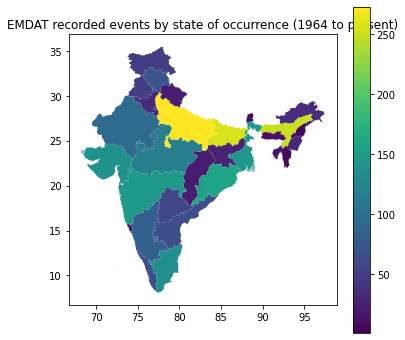

In [329]:
gdf.plot(column='count',figsize=[6,6],legend=True)
plt.title('EMDAT recorded events by state of occurrence (1964 to present)');

In [331]:
event_count.head()

,count
Uttar Pradesh,273
Bihar,258
Assam,250
Odisha,160
Maharashtra,147


In [332]:
print(event_count.sum())

count    2493
dtype: int64


In [333]:
len(df)

1403

In [378]:
nullcount=0
nullseries = np.zeros(len(df))
for enum, state in enumerate(df.states):
    if not state[0]:
        nullcount+=1
        nullseries[enum] = 1
        
print("There were {} nulls".format(nullcount))
print("Or {:.1f}% of total rows".format(nullcount/len(df)*100))

There were 613 nulls
Or 43.7% of total rows


In [387]:
df[nullseries==1]

,dis_no,year,event_name,disaster_type,location,lat,lon,deaths,affected,total_damages,location_split,states
3,1965-9073-IND,1965-01-01,NaN,Drought,Nationwide except south,NaN,NaN,1500000.00,100000000.00,100000.00,[nationwide south],[None]
5,1965-0105-IND,1965-01-01,Mine,Industrial accident,Chinakuri,NaN,NaN,200.00,NaN,NaN,[chinakuri],[None]
9,1967-0091-IND,1967-01-01,NaN,Miscellaneous accident,Maraksagar,NaN,NaN,100.00,NaN,NaN,[maraksagar],[None]
10,1968-0055-IND,1968-01-01,NaN,Flood,"(1) Rajasthan, Gujarat - (2) North-East, West ...",NaN,NaN,4892.00,7500000.00,94200.00,"[1 rajasthan, gujarat - 2 north-east, west b...","[None, None, West Bengal, Assam]"
12,1968-0084-IND,1968-01-01,NaN,Storm,"Ramanathapurum, Thanjavur",NaN,NaN,7.00,15000.00,NaN,"[ramanathapurum, thanjavur]","[None, Tamil Nadu]"
...,...,...,...,...,...,...,...,...,...,...,...,...
1390,2020-0220-IND,2020-01-01,NaN,Landslide,"Barak Valley Region (southern Assam State, nor...",NaN,NaN,21.00,155850.00,NaN,"[barak valley region southern assam , north-e...","[None, None]"
1396,2020-0525-IND,2020-01-01,Chemical plant,Industrial accident,Near Ahmedabad (Gujarat State),NaN,NaN,12.00,NaN,NaN,[near ahmedabad gujarat ],[None]
1397,2020-0170-IND,2020-01-01,NaN,Industrial accident,Visakhapatnam district (Andra Pradesh),NaN,NaN,11.00,NaN,NaN,[visakhapatnam ra pradesh],[None]
1398,2020-0435-IND,2020-01-01,Building,Miscellaneous accident,Bhiwandi (near Bombay),NaN,NaN,44.00,NaN,NaN,[bhiwi near bombay],[None]
